In [332]:
#https://www.kaggle.com/c/tmdb-box-office-prediction/data

In [333]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

In [334]:
train = pd.read_csv('tmdb-box-office-prediction/train.csv')
test = pd.read_csv('tmdb-box-office-prediction/test.csv')

In [335]:
train['dataset'] = 'train'
test['dataset'] = 'test'

train = train.append(test);

train.reset_index(inplace=True, drop=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


I don't want to repeat any data wrangling twice, I will split the datasets before training the model.

### Exploratory data analysis

In [336]:
train.dataset.unique()

array(['train', 'test'], dtype=object)

In [337]:
# First of all, let's get an understanding of our dependent variable

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


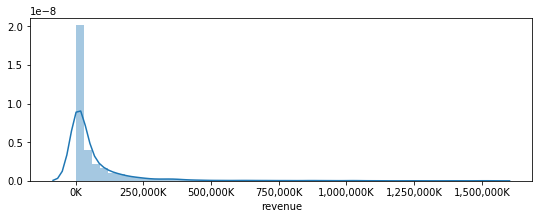

In [338]:
plt.figure(figsize=(9, 3))
g = sns.distplot(train[train.revenue.notnull()]['revenue'])

xlabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(xlabels);

The vast majority are productions with little revenue, with a couple of outliers raking in hundreds of millions

In [339]:
train.sort_values("revenue")[['title', 'revenue', 'release_date']].head(10)

,title,revenue,release_date
347,The Wind in the Willows,1.00,10/16/96
1754,Mute Witness,1.00,9/28/95
1917,The Merry Widow,1.00,8/26/25
1874,Missing,1.00,1/1/07
695,Tere Naam,2.00,8/15/03
334,Saamy,3.00,5/5/03
1541,All at Once,3.00,6/5/14
2383,Borsalino,3.00,5/19/70
2117,American Adobo,4.00,9/29/01
1346,East of Eden,5.00,3/9/55


I'm having doubts about such low revenue values... How can a movie have revenue of 1? <br>
Unless what is meant here is profit, and not revenue?

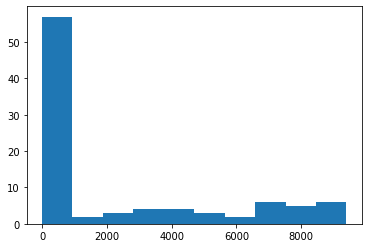

In [340]:
(n, bins, patches) = plt.hist(train[train.revenue < 10000]['revenue'])
plt.ticklabel_format(style='plain')

From the histogram it's visible that plotting the movies with low revenue (less than 10k), the smallest bin
is biggest. <br>This suggests the data was input wrongly (i.e. 12 means 12 thousand). Otherwise we would see
a more-less smooth, continuous distribution. Keeping these data points in, will drive the regression coefficients towards zero, 
acting a bit like an L2 penalty, which prevents overfitting, but in our case it would simply mean wrong predictions. I will drop the values in the smallest bin.

In [341]:
bins[1]

940.1

In [342]:
#train = train[train.revenue > bins[1]]

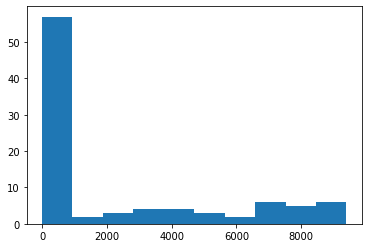

In [343]:
#plt.figure()
plt.hist(train[train.revenue < 10000]['revenue']);

In [344]:
#plt.ticklabel_format(useOffset=False, style='plain')

### Language

In [345]:
train['is_english'] = train.original_language == 'en'

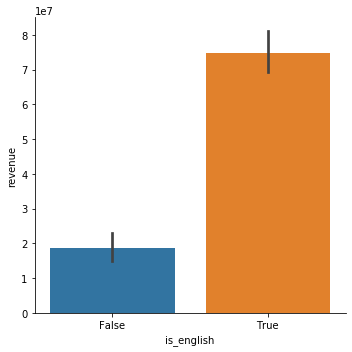

In [346]:
sns.catplot(x="is_english", y='revenue', data=train, kind='bar', );

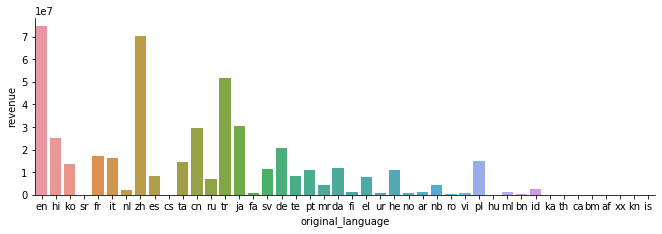

In [347]:
cat = sns.catplot(x="original_language", y='revenue', data=train, kind='bar',ci=None );
cat.fig.set_size_inches(10, 3)

In [348]:
train.original_language.value_counts()[:15]

en    6351
fr     199
hi     118
ru     109
es      95
ja      90
it      56
de      49
ko      49
zh      46
cn      41
ta      31
sv      20
da      17
pt      13
Name: original_language, dtype: int64

English language movies bring in most revenue, but so do turkish or chinese ones.<br>
However, we don't have enough data points for those non-english movies to generalize well.<br>
I will only use one binary feature english vs. non english

In [349]:
train.drop('original_language', axis=1, inplace=True)

### Sequels

It could be that sequels fetch less/more money than original movies  as they generally tend to be worse.<br>
I have a column telling me if a movie belongs to a collection, but it doesn't tell me if it's the first movie, or a subsequent one

In [350]:
train['sequel'] = train.title.str.findall("\s\d$").apply(bool)

In [351]:
train.title = train.title.str.replace("VIII", "8")
train.title = train.title.str.replace("VII", "7")
train.title = train.title.str.replace("VI", "6", case=True)
train.title = train.title.str.replace("\sV", "5")
train.title = train.title.str.replace("IV", "4")

train.title = train.title.str.replace("III", "3")
train.title = train.title.str.replace("II", "2")
train.title = train.title.str.replace("\sI[\s:]", "1")

In [352]:
train[train.title.isnull()]

,Keywords,belongs_to_collection,budget,cast,crew,dataset,genres,homepage,id,imdb_id,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,is_english,sequel
5398,NaN,NaN,0,"[{'cast_id': 3, 'character': 'Boduri', 'credit...","[{'credit_id': '52fe4bd7c3a36847f8216183', 'de...",test,"[{'id': 18, 'name': 'Drama'}, {'id': 16, 'name...",http://wwws.warnerbros.co.jp/budori/,5399,tt2391821,...,NaN,7/7/12,nan,106.00,NaN,Released,NaN,NaN,False,True
5425,NaN,"[{'id': 115840, 'name': 'Would I Lie to You? C...",25496629,"[{'cast_id': 2, 'character': 'Eddie', 'credit_...","[{'credit_id': '552bb9a09251417c29001c7a', 'de...",test,"[{'id': 35, 'name': 'Comedy'}]",http://www.laveritesijemens3.com/,5426,tt1794850,...,NaN,1/31/12,nan,120.00,NaN,Released,NaN,NaN,False,True
6628,"[{'id': 2487, 'name': 'naivety'}, {'id': 9714,...",NaN,6000000,"[{'cast_id': 3, 'character': 'Daisy', 'credit_...","[{'credit_id': '52fe4ec2c3a36847f82a65a7', 'de...",test,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",http://barefootthemovie.com/,6629,tt2355495,...,NaN,2/2/14,nan,90.00,NaN,Released,NaN,NaN,True,True


In [353]:
train.title.fillna('missing', inplace=True)
train[train.title.str.contains("\s\d$|\s\d:")]['title'].head(10)

0                             Hot Tub Time Machine 2
1           The Princess Diaries 2: Royal Engagement
11         Revenge of the Nerds 2: Nerds in Paradise
19                                     Transporter 2
21                            Friday the 13th Part 3
33                                   ABCs of Death 2
34                                       Rush Hour 3
63     Friday the 13th Part 8: Jason Takes Manhattan
90                                  Kill Bill:5ol. 1
104                                   Recep İvedik 4
Name: title, dtype: object

In [354]:
train['part'] = train.title.str.findall("\s\d$|\s\d:")

In [355]:
train.part = train.part.str[0]

In [356]:
train.part = train.part.str.replace("\:", "").str.strip()

In [357]:
train[train.part.notnull()]['part'].unique()

array(['2', '3', '8', '1', '4', '5', '9', '6', '7'], dtype=object)

In [358]:
train.part.fillna(1, inplace=True)

In [359]:
train['sequel'] = train.part != 1

In [360]:
train[train.sequel == True][['sequel', 'title']].head(10)

,sequel,title
0,True,Hot Tub Time Machine 2
1,True,The Princess Diaries 2: Royal Engagement
11,True,Revenge of the Nerds 2: Nerds in Paradise
19,True,Transporter 2
21,True,Friday the 13th Part 3
33,True,ABCs of Death 2
34,True,Rush Hour 3
63,True,Friday the 13th Part 8: Jason Takes Manhattan
90,True,Kill Bill:5ol. 1
104,True,Recep İvedik 4


In [361]:
#train.drop('part', axis=1, inplace=True)

Let's see if my assumption was correct, that sequels are worse than originals and bring less revenue

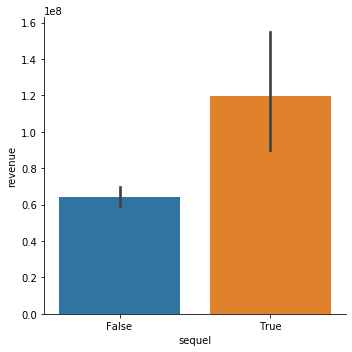

In [362]:
sns.catplot(x='sequel', y='revenue', data=train, kind='bar');

It wasn't, it was exactly the opposite. But the difference is big enough to keep it as a feature

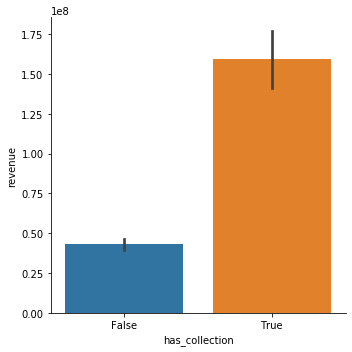

In [363]:
train['has_collection'] = train.belongs_to_collection.notnull();
sns.catplot(x='has_collection', y='revenue', data=train, kind='bar')

This actually looks like a better feature than the one I created myself.

### Budget

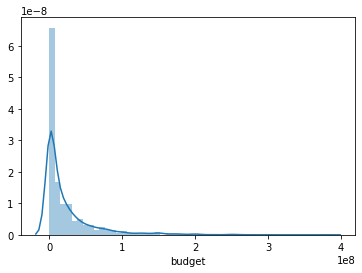

In [364]:
sns.distplot(train.budget);

In [365]:
train[train.dataset == 'test']['budget'][:10]

3000           0
3001       88000
3002           0
3003     6800000
3004     2000000
3005           0
3006           0
3007    30000000
3008    16500000
3009    90000000
Name: budget, dtype: int64

In [366]:
(train.budget == 0).value_counts(dropna=False)

False    5375
True     2023
Name: budget, dtype: int64

We got a lot of missing values, which is a problem, because budget could be one of the strongest predictors of revenue.<br> It's a double whammy, because I have very little data and cannot affort to simply drop these rows.

First, I need to understand if this feature is missing at random, or if there is some logic to it.

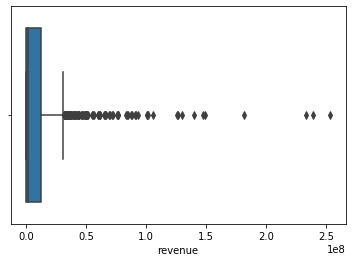

In [367]:
sns.boxplot(train[train.budget == 0]['revenue'])

It looks random.

In [368]:
mask = train.budget == 0
mask1 = train.dataset == 'train'

(train[mask & mask1]['revenue'].mean(), train[~mask & mask1]['revenue'].median())

(12187006.383004926, 28910632.0)

It's 12 mln vs 28 mln. The difference actually is not SO big...

In [369]:
bud = train[train.budget > 0]

In [370]:
bud[bud.dataset == 'train'].sort_values('budget')[['budget', 'revenue']][:20]

,budget,revenue
849,1,8500000.00
2255,1,100.00
1346,1,5.00
334,1,3.00
695,1,2.00
1754,2,1.00
2032,4,25.00
1800,5,135.00
1198,5,85.00
639,6,8.00


Budgets lower than 2500 seems to be wrong too, in some other unit. I prefer to treat them as 0.

In [371]:
train.loc[ (train.budget < 2500) ]['budget'] = 0

In [372]:
bud = train[train.budget > 2000]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


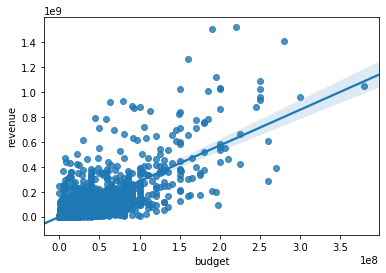

In [373]:
sns.regplot(bud.budget, bud.revenue);

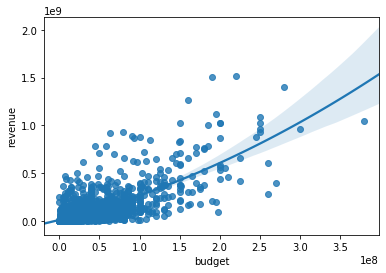

In [374]:
sns.regplot(bud.budget, bud.revenue, order=2);

In [375]:
from scipy.stats import pearsonr
corr, _ = pearsonr(bud[bud.dataset == 'train']['budget'], bud[bud.dataset == 'train']['revenue'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.739


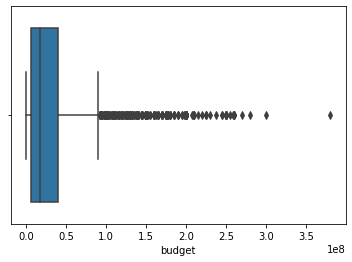

In [376]:
sns.boxplot(bud.budget)

I don't think it's a good idea to just fill these nans with a mean or a median, because the data is really spread out.<br> Given the strong correlation, I will go out on a limb and use ML to guess these missing values. But doing this feels almost like predicting revenue itself.

### Filling in missing budget values using simple regression

In [377]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X=np.array(bud[bud.dataset == 'train']['revenue']).reshape(-1, 1), \
                               y=np.array(bud[bud.dataset == 'train']['budget']).reshape(-1, 1))

In [378]:
budgets_ml = model.predict(np.array(train[(train.budget == 0) & (train.dataset == 'train')]['revenue']).reshape(-1, 1))

In [379]:
train.loc[(train.budget == 0) & (train.dataset == 'train')]['budget'] = budgets_ml.tolist()

### Not so fast....

The predictions 'work', but are worthless, as the data I used to get them (revenue - my target variable) is present only in the train dataset, of course. So I cannot do the same in the test dataset. To predict budget, I need to use features present in both train and test dataset.

### Genre

In [380]:
train.genres[0]

"[{'id': 35, 'name': 'Comedy'}]"

its a string dictionary because the data was uploaded to kaggle as csv and not as pickle :-/ but we got a fix

In [381]:
import ast
ast.literal_eval(train.genres[0])

[{'id': 35, 'name': 'Comedy'}]

In [382]:
train.genres = train.genres.apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else None)

In [383]:
sum(train.genres.isnull())

23

In [384]:
# we can live with that

In [385]:
def extract_genres(x):
    if x:
        return [d['name'] for d in x]

train.genres = train.genres.apply(extract_genres)

In [386]:
train.genres[:10]

0                                      [Comedy]
1              [Comedy, Drama, Family, Romance]
2                                       [Drama]
3                             [Thriller, Drama]
4                            [Action, Thriller]
5                [Animation, Adventure, Family]
6                            [Horror, Thriller]
7                                 [Documentary]
8    [Action, Comedy, Music, Family, Adventure]
9                               [Comedy, Music]
Name: genres, dtype: object

We have to turn the list of genres into onehotencoding

In [387]:
from pandas.core.common import flatten
genres = [g for g in set(flatten(train.genres.tolist())) if g]

In [388]:
print(genres)

['Documentary', 'Crime', 'Family', 'Romance', 'Music', 'Horror', 'Action', 'War', 'Animation', 'Foreign', 'Comedy', 'Western', 'Science Fiction', 'History', 'TV Movie', 'Fantasy', 'Adventure', 'Mystery', 'Thriller', 'Drama']


In [389]:
for genre in genres:
    train[genre] = 0

In [390]:
for genre in genres:
    train[genre] = train.genres.apply(lambda x: genre in x if x else None)

In [391]:
genre_dict = {}

for genre in genres:
    #print(genre)
    #print(sum(train[genre].fillna(0)), "\n\n")
    genre_dict[genre] = ( train[train[genre] == True]['revenue'].mean(),
                         train[train[genre] == True]['revenue'].median(),
                         len(train[train[genre] == True])
                        ) 

In [392]:
gen_df = pd.DataFrame(genre_dict).T

In [393]:
gen_df.columns = ['mean', 'median', 'count']

In [394]:
gen_df.reset_index(inplace=True)

In [395]:
gen_df.sort_values('mean', ascending=False)

,index,mean,median,count
16,Adventure,175809498.86,59700000.00,1116.00
15,Fantasy,147965932.84,49813196.00,628.00
8,Animation,147734092.27,36754634.00,382.00
2,Family,138897794.86,57470029.50,675.00
12,Science Fiction,122367176.31,35109301.50,744.00
6,Action,111043446.51,36000000.00,1735.00
18,Thriller,68336641.40,21890845.00,1869.00
10,Comedy,60875742.92,18809184.00,2605.00
17,Mystery,59633963.76,21133087.00,550.00
1,Crime,59491276.82,24048000.00,1084.00


According to the law of large numbers, we are more likely to see very low or very high averages when the sample size is small.<br> Something to keep in mind here.

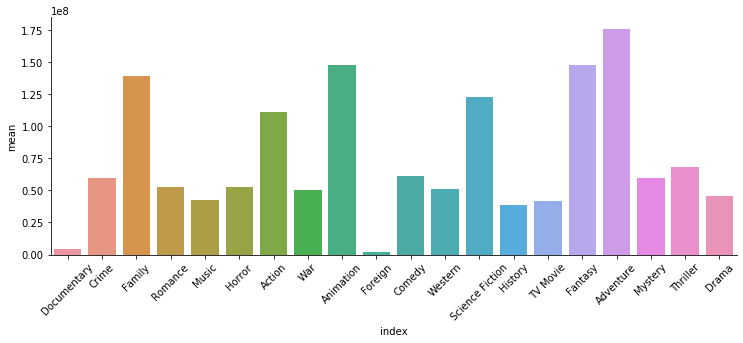

In [396]:
f = sns.catplot(x='index', y= 'mean', data=gen_df, kind='bar')
f.fig.set_size_inches(12, 4)
f.set_xticklabels( rotation=45)

### Popularity

I'm not sure what popularity is, given the fact that the aim of this competition is to predict revenue PRIOR TO the release of a movie.

In [397]:
corr, _ = pearsonr(train.popularity, train.revenue)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: nan


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


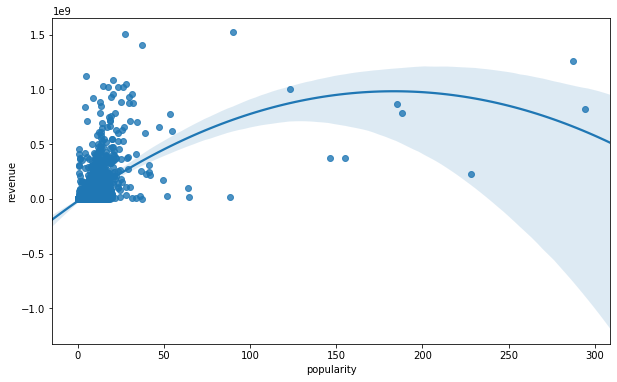

In [398]:
f = sns.regplot(train.popularity, train.revenue, order=2);
f.figure.set_size_inches(10, 6)

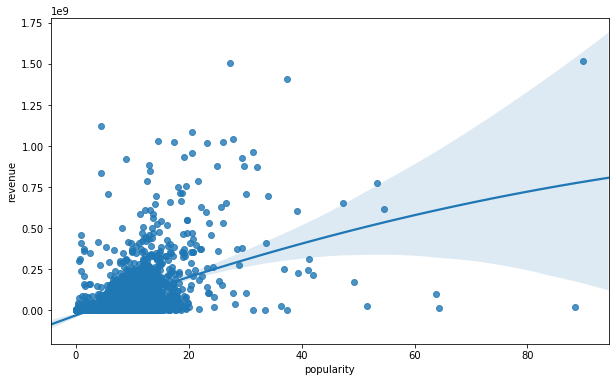

In [399]:
no_outliers = train[train.popularity < 100]
f = sns.regplot(no_outliers.popularity, no_outliers.revenue, order=2);
f.figure.set_size_inches(10, 6)

I am not convinced it is a good feature, the correlation is rather weak, and fitting a linear regression line, even of a 2nd order, and even dropping the outliers, still looks forced to me.

### Release Date

This could be relevant, because of the inflation and rising prices across the decades.

In [400]:
train.release_date[:5]

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

In [401]:
train = train[~train.release_date.isnull()]

In [402]:
train['year'] = train.release_date.str[-2:]#.apply(int)
train.year = train.year.apply(lambda x: "20" + x if int(x) < 20 else "19" + x).apply(int)

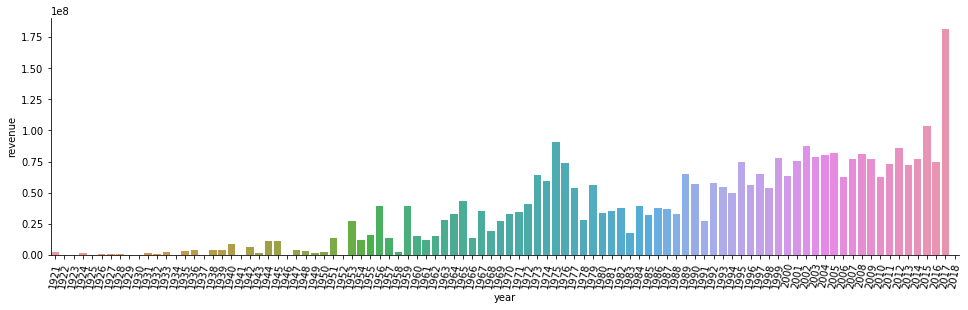

In [403]:
f = sns.catplot(x='year', y= 'revenue', data=train, kind='bar', ci=None)
f.fig.set_size_inches(16, 4)
f.set_xticklabels( rotation=80)

the hunch was correct!

In [405]:
train.corr()['revenue']

budget           0.75
id               0.00
popularity       0.46
revenue          1.00
runtime          0.22
is_english       0.14
sequel           0.08
has_collection   0.34
year             0.14
Name: revenue, dtype: float64

I am surprised why year has no correlation with revenue, if from the graph we can clearly see a relationship.

I am going to bin this feature, even though the literature says that 9 out of 10, you should not bin as you will throw away important trends. In this case, I don't believe there is a relationship between a specific year, and revenue. What is there, however, is a general trend, with rising revenue with passing time. This is unwanted granularity to me. I want to smooth this trend out, by removing outliers, and this can be achieved by binning, taking the median.

In [427]:
train['year_bins'] = pd.cut(train.year, bins=11)

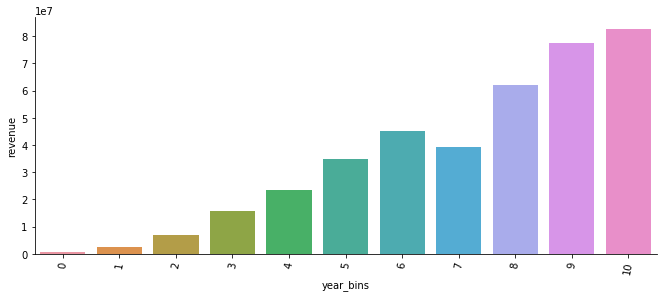

In [463]:
f = sns.catplot(x='year_bins', y= 'revenue', data=train, kind='bar', ci=None, estimator=np.mean)
f.fig.set_size_inches(10, 4)
f.set_xticklabels( rotation=80)

This looks like more meaningful and generizable than without binning. It will also prevent overfitting, in case you have only one or few movies made in e.g. 1974 with super high revenue.

In [447]:
train['year_bins'] = pd.cut(train.year, bins=11, labels=range(11))

In [459]:
from scipy.stats import pearsonr
corr, _ = pearsonr(train[train.dataset == 'train'].year_bins, train[train.dataset == 'train'].revenue)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.134


This didn't work as I expected, didn't increase the correlation.

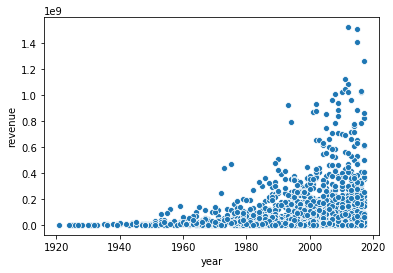

In [462]:
sns.scatterplot(train[train.dataset == 'train']['year'], train[train.dataset == 'train']['revenue'])

The reason for the weak correlation could be the fact that even though all the high revenue movies were produced recently, there are lots of low revenue movies that are recent too. And the multimillion movies blow everything out of proportion.

In [328]:
train.drop('release_date', inplace=True, axis=1)

### Runtime

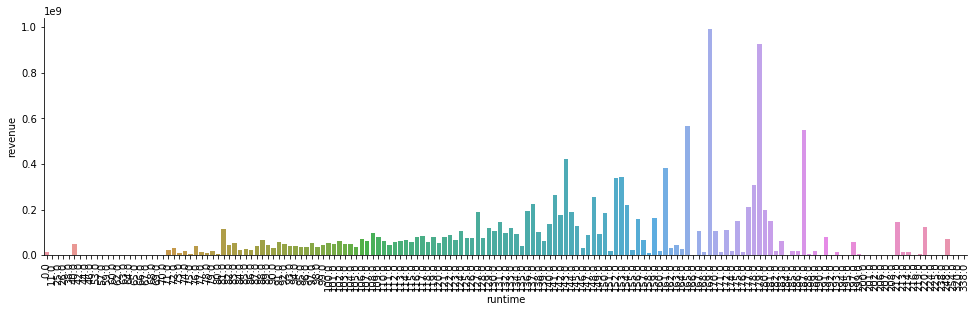

In [464]:
f = sns.catplot(x='runtime', y= 'revenue', data=train, kind='bar', ci=None)
f.fig.set_size_inches(16, 4)
f.set_xticklabels( rotation=90)

The shortest movies never bring much revenue, but with average and long duration, it looks very random. I think that here, just like in the case of production year, smoothing out this feature could result in better generalization of the model.

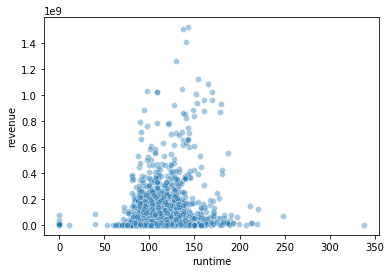

In [474]:
sns.scatterplot(train[train.dataset == 'train']['runtime'], train[train.dataset == 'train']['revenue'], alpha=0.4)

In [ ]:
sns.scatterplot(train.runtime, train.revenue)

My first hunch was to bin this continous variable into 3 categories: too short, average, too long, but looking at the scatterplot I think I would throw away some useful information by doing that. Especially because the scatter looks a bit like a "normal" distribution, with the points slowly ascending towards its peak.

### Website

I'm not going to scrape the websites, but the missing data might be an indicator of movie's quality.

In [ ]:
plt.bar(x=['with website', 'without website'], 
        height=[train[train.homepage.notnull()]['revenue'].median(), 
                train[train.homepage.isnull()]['revenue'].median()]);

In [ ]:
train.homepage = train.homepage.notnull()

In [ ]:
train.status.value_counts()

### Tagline

In [ ]:
train.tagline.tolist()[:10]

In [ ]:
plt.bar(x=['with tagline', 'without tagline'], 
        height=[train[train.tagline.notnull()]['revenue'].median(), 
                train[train.tagline.isnull()]['revenue'].median()]);

In [ ]:
train['has_tagline'] = train.tagline.notnull()

In [ ]:
sum(train.tagline.isnull())

### Production company

We already know that english language movies have higher revenue. Production companies could let us further differentiate within english movies.

In [ ]:
plt.bar(x=['with', 'without'], 
        height=[train[train.production_companies.notnull()]['revenue'].median(), 
                train[train.production_companies.isnull()]['revenue'].median()]);

In [ ]:
train['has_production'] = train.production_companies.notnull()

In [ ]:
train.production_companies = train.production_companies.apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else None)

The first position in the dictionary seems to be the main production company, so I will take only that one.

In [ ]:
train.production_companies = train.production_companies.str[0]

In [ ]:
train['prod_id'] = train.production_companies.apply(lambda x: x['id'] if pd.notnull(x) else None)
train['prod_name'] = train.production_companies.apply(lambda x: x['name'] if pd.notnull(x) else None)

In [ ]:
train.prod_name.value_counts()[:10]

Production company is an example of categorical data with high cardinality. Normally, I would use onehotencoding, but in this case, it will slow down the model (too many features), given many categories with only 1 member. Moreover, it can be prone to overfitting. I will solve this issue by adding a new column, 'company_avg' which is the average of the revenue within the group. The problem this poses, in turn, is that I will have to create this column in the test data too, with values from the train data. But given high cardinality, it will happen that many production companies in the test data are not in the train data, so i have no value to input there.

In [ ]:
sum(train.prod_name.value_counts() < 3)

In [ ]:
agg = train[['prod_name', 'revenue']].groupby('prod_name').agg({'prod_name' : 'size', 
                                                                'revenue' : ['mean', np.std ],
                                                               })
#agg.rename({'prod_name' : 'count'}, inplace=True, axis=1)
#agg.reset_index(inplace=True)
#agg = agg.sort_values('count', ascending=False)

In [ ]:
agg.head()

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(x=agg.prod_name[:10].tolist(), height=agg.revenue[:10].tolist(), )
plt.xticks(rotation=80);

Another option is using onehot only on a subset of production companies, fulfilling following criteria:<br>
1. Enough members of a group
2. Low standard deviation
<br>

In [ ]:
#agg = agg[agg['prod_name']['size'] > 10]

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
agg.sort_values([ ('revenue', 'std') ])[:5]

In theory, companies that produce a lot of movies, are successful. Otherwise, they would go bankrupt if they produced flops.<br> Let's check if there is a relationship with size of company and revenue.

In [ ]:
size_stats = agg.groupby([('prod_name', 'size')]).agg({ ('revenue', 'mean') : np.mean})

In [ ]:
size_stats[('revenue', 'mean')]

In [ ]:
sns.barplot(x=size_stats.index, y=size_stats[('revenue', 'mean')])

In [ ]:
# Not what I expected. I'm oficially abandoning this feature

In [329]:
train.corr()[['revenue']]

,revenue
budget,0.75
id,0.00
popularity,0.46
revenue,1.00
runtime,0.22
is_english,0.14
sequel,0.08
has_collection,0.34


# Model selection

In [ ]:
train.columns

In [ ]:
train = train[['id', 'is_english', 'has_collection', 'budget', 'runtime','dataset',
               'year', 'has_tagline', 'has_production'
               
               'Fantasy', 'Animation', 'Thriller', 'Mystery',
               'Comedy', 'Action', 'Foreign', 'History', 'Family', 'Horror',
               'TV Movie', 'War', 'Western', 'Romance', 'Music', 'Science Fiction',
               'Documentary', 'Crime', 'Drama', 'Adventure'
               
               'revenue']]